Predicted Class: goldfish


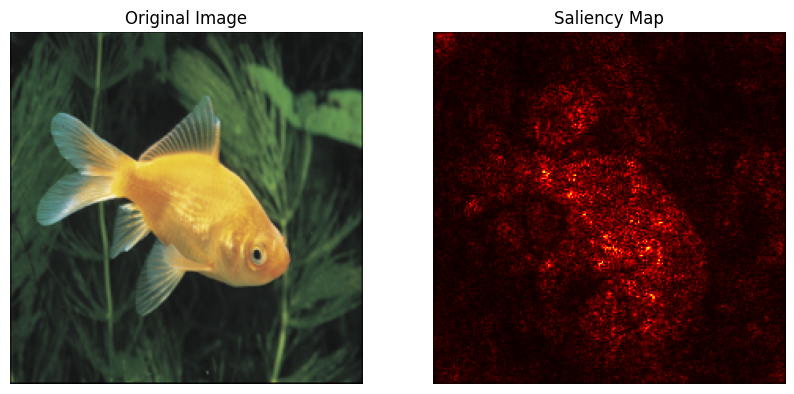

In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import requests


# 1. Load Pretrained ResNet
# model = models.resnet18()
# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
# model = models.vgg16()

model.eval()  # Set model to evaluation mode

# 2. Load and preprocess the image
def preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = Image.open(image_path).convert('RGB')
    img_resized = img.resize((224, 224))
    img_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension
    return img_tensor, img_resized, img

image_path = 'n01443537_goldfish.jpg'  # Replace with your image path
# image_path = 'n01614925_bald_eagle.jpg'  # Replace with your image path
# image_path = 'n01558993_robin.jpg'  # Replace with your image path
# image_path = 'n01796340_ptarmigan.jpg'  # Replace with your image path


img_tensor, img_resized, original_img = preprocess_image(image_path)

# 3. Enable gradient computation for the input image
img_tensor.requires_grad_()

# 4. Forward pass through the model
output = model(img_tensor)

# 5. Get the index of the predicted class
predicted_class = output.argmax().item()

# Get the predicted class index
_, predicted_idx = torch.max(output, 1)

LABELS_URL = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
labels = requests.get(LABELS_URL).json()

# Decode the predicted class
predicted_class_name = labels[predicted_idx.item()]

print(f'Predicted Class: {predicted_class_name}')

# 6. Backpropagate to compute gradients
model.zero_grad()
output[0, predicted_class].backward()

# 7. Get saliency map by taking the absolute value of the gradients
saliency_map = img_tensor.grad.data.abs().squeeze().max(dim=0)[0]

# 8. Visualize the saliency map
def show_saliency_map(original_img, saliency_map):
    plt.figure(figsize=(10, 5))

    # Display the original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.axis('off')
    plt.title('Original Image')

    # Display the saliency map
    plt.subplot(1, 2, 2)
    plt.imshow(saliency_map.numpy(), cmap='hot')
    plt.axis('off')
    plt.title('Saliency Map')

    plt.show()

show_saliency_map(img_resized, saliency_map)

